# Mid-Bootcamp Project
## Exploring historical property sales data.

# Import all Libraries

In [528]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm

from statsmodels.sandbox.regression.predstd import wls_prediction_std
%matplotlib inline
import mpl_toolkits

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from mlxtend.plotting import plot_decision_regions
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

# Import and check data

In [590]:
rawdata = pd.read_csv("regression_data_clean.csv")
rawdata.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,7129300520,10/13/14,3,1.000,1180,5650,1.000,0,0,3,7,1180,0,1955,0,98178,47.511,-122.257,1340,5650,221900
1,6414100192,12/9/14,3,2.250,2570,7242,2.000,0,0,3,7,2170,400,1951,1991,98125,47.721,-122.319,1690,7639,538000
2,5631500400,2/25/15,2,1.000,770,10000,1.000,0,0,3,6,770,0,1933,0,98028,47.738,-122.233,2720,8062,180000
3,2487200875,12/9/14,4,3.000,1960,5000,1.000,0,0,5,7,1050,910,1965,0,98136,47.521,-122.393,1360,5000,604000
4,1954400510,2/18/15,3,2.000,1680,8080,1.000,0,0,3,8,1680,0,1987,0,98074,47.617,-122.045,1800,7503,510000


In [591]:
rawdata.shape

(21597, 21)

In [592]:
# Convert the date column into pandas datetime for sorting.

rawdata['date'] = pd.to_datetime(rawdata['date'])

## There were a number of duplicate ids, so to give a more accurate picture of the current property market, I  used only the most recent sale data from duplicated properties.

In [593]:
rawdata = rawdata.sort_values(by=['id', 'date'])

In [594]:
rawdata = rawdata.drop_duplicates(['id'], keep='last')

In [595]:
rawdata_duplicates = rawdata[rawdata.duplicated(['id'], keep=False)]

In [596]:
rawdata_duplicates

#No duplicate ids found

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price


In [597]:
rawdata.shape

(21420, 21)

### Now to sort the columns with lots of 0s

In [598]:
#A function to reduce columns with limited data into boolean

def ColumnReducer (x):
    if x == 0:
        n = 0
    elif x > 0:
        n = 1
    return n


In [599]:
rawdata['waterfront'] = rawdata['waterfront'].apply(ColumnReducer)
rawdata['view'] = rawdata['view'].apply(ColumnReducer)
rawdata['sqft_basement'] = rawdata['sqft_basement'].apply(ColumnReducer)
rawdata['renovated'] = rawdata['yr_renovated'].apply(ColumnReducer)

In [600]:
rawdata.reset_index()
rawdata.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price,renovated
2495,1000102,2015-04-22,6,3.000,2400,9373,2.000,0,0,3,7,2400,0,1991,0,98002,47.326,-122.214,2060,7316,300000,0
6729,1200019,2014-05-08,4,1.750,2060,26036,1.000,0,0,4,8,1160,1,1947,0,98166,47.444,-122.351,2590,21891,647500,0
8404,1200021,2014-08-11,3,1.000,1460,43000,1.000,0,0,3,7,1460,0,1952,0,98166,47.443,-122.347,2250,20023,400000,0
8800,2800031,2015-04-01,3,1.000,1430,7599,1.500,0,0,4,6,1010,1,1930,0,98168,47.478,-122.265,1290,10320,235000,0
3553,3600057,2015-03-19,4,2.000,1650,3504,1.000,0,0,3,7,760,1,1951,2013,98144,47.580,-122.294,1480,3504,402500,1


### There are a number of columns that will not be help with the model so I will drop them before further exploration

In [601]:
rawdata = rawdata.drop(["id","date","lat","long","yr_renovated"], axis=1)

### The sqft_living and sqft_lot have more recent values in sqft_living15 and sqft_lot. So will drop the older values for a more up to date value of each property.

In [602]:
rawdata = rawdata.drop(["sqft_living","sqft_lot"], axis=1)

### Now for a quick look at the data

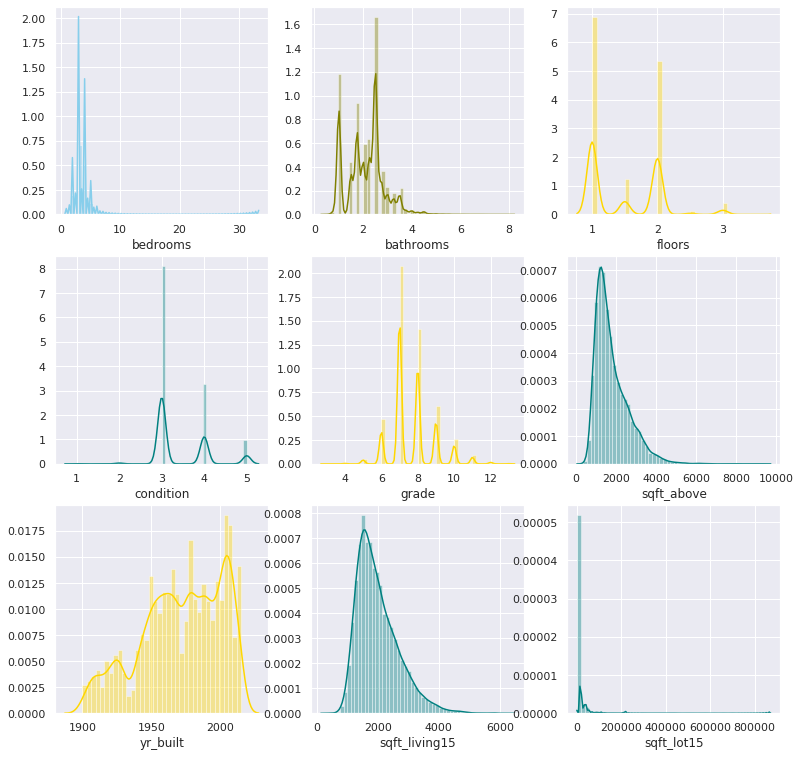

In [603]:
f, axes = plt.subplots(3, 3, figsize=(13, 13), sharex=False)
sns.distplot( rawdata["bedrooms"] , color="skyblue", ax=axes[0, 0])
sns.distplot( rawdata["bathrooms"] , color="olive", ax=axes[0, 1])
sns.distplot( rawdata["floors"] , color="gold", ax=axes[0, 2])
sns.distplot( rawdata["condition"] , color="teal", ax=axes[1, 0])
sns.distplot( rawdata["grade"] , color="gold", ax=axes[1, 1])
sns.distplot( rawdata["sqft_above"] , color="teal", ax=axes[1, 2])
sns.distplot( rawdata["yr_built"] , color="gold", ax=axes[2, 0])
sns.distplot( rawdata["sqft_living15"] , color="teal", ax=axes[2, 1])
sns.distplot( rawdata["sqft_lot15"] , color="teal", ax=axes[2, 2])

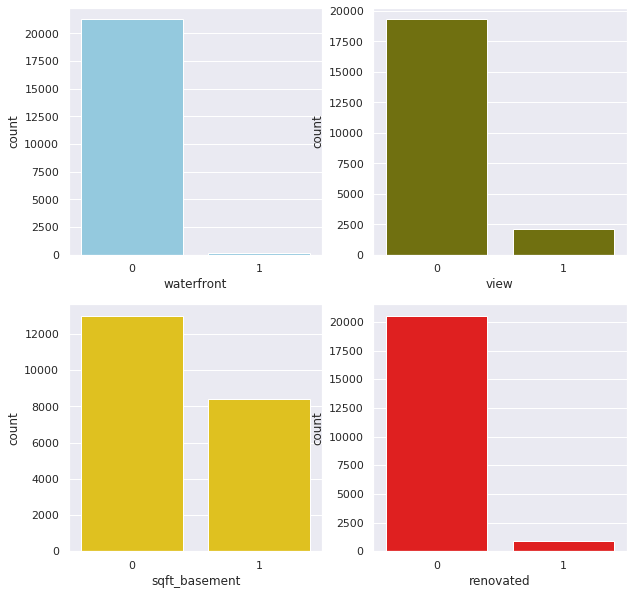

In [604]:
f, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=False)
sns.countplot( rawdata["waterfront"] , color="skyblue", ax=axes[0, 0])
sns.countplot( rawdata["view"] , color="olive", ax=axes[0, 1])
sns.countplot( rawdata["sqft_basement"] , color="gold", ax=axes[1, 0])
sns.countplot( rawdata["renovated"] , color="red", ax=axes[1, 1])

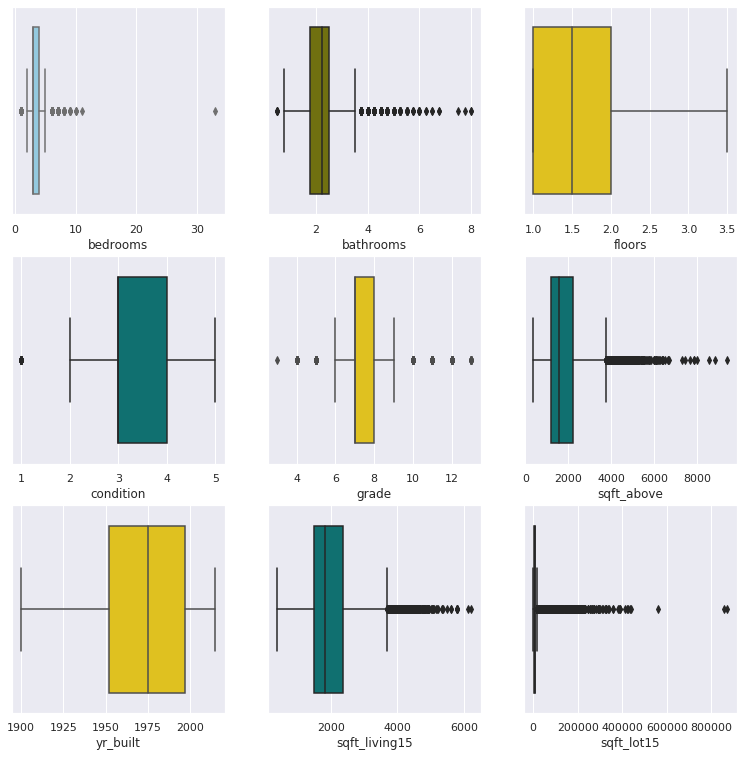

In [605]:
f, axes = plt.subplots(3, 3, figsize=(13, 13), sharex=False)
sns.boxplot( rawdata["bedrooms"] , color="skyblue", ax=axes[0, 0])
sns.boxplot( rawdata["bathrooms"] , color="olive", ax=axes[0, 1])
sns.boxplot( rawdata["floors"] , color="gold", ax=axes[0, 2])
sns.boxplot( rawdata["condition"] , color="teal", ax=axes[1, 0])
sns.boxplot( rawdata["grade"] , color="gold", ax=axes[1, 1])
sns.boxplot( rawdata["sqft_above"] , color="teal", ax=axes[1, 2])
sns.boxplot( rawdata["yr_built"] , color="gold", ax=axes[2, 0])
sns.boxplot( rawdata["sqft_living15"] , color="teal", ax=axes[2, 1])
sns.boxplot( rawdata["sqft_lot15"] , color="teal", ax=axes[2, 2])

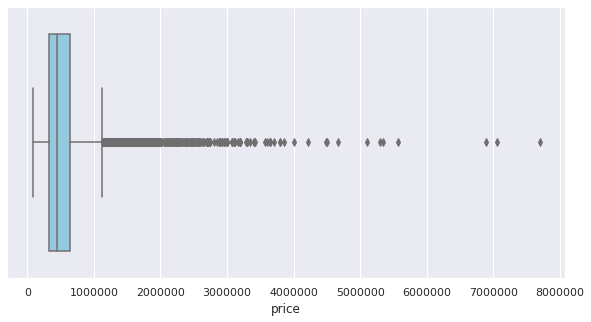

In [606]:
plt.figure(figsize=(10,5))
sns.boxplot( rawdata["price"] , color="skyblue")


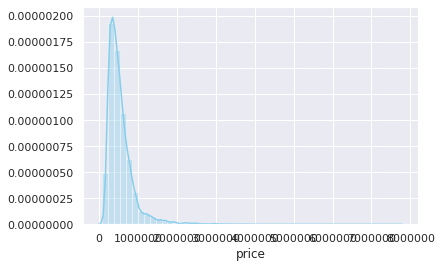

In [607]:
sns.distplot( rawdata["price"] , color="skyblue")


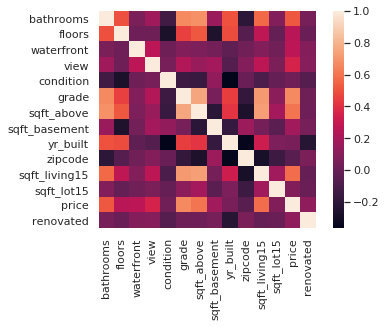

In [608]:
corr = rawdata.select_dtypes(include = ['float64', 'int64']).iloc[:,1:].corr()
#fig = plt.figure()
sns.set(font_scale=1)  
sns.heatmap(corr, vmax=1, square=True)

In [609]:
corr_list = corr['price'].sort_values(axis=0,ascending=False).iloc[1:]
corr_list

grade            0.667
sqft_above       0.604
sqft_living15    0.584
bathrooms        0.525
view             0.358
waterfront       0.267
floors           0.255
sqft_basement    0.180
renovated        0.126
sqft_lot15       0.082
yr_built         0.051
condition        0.034
zipcode         -0.051
Name: price, dtype: float64

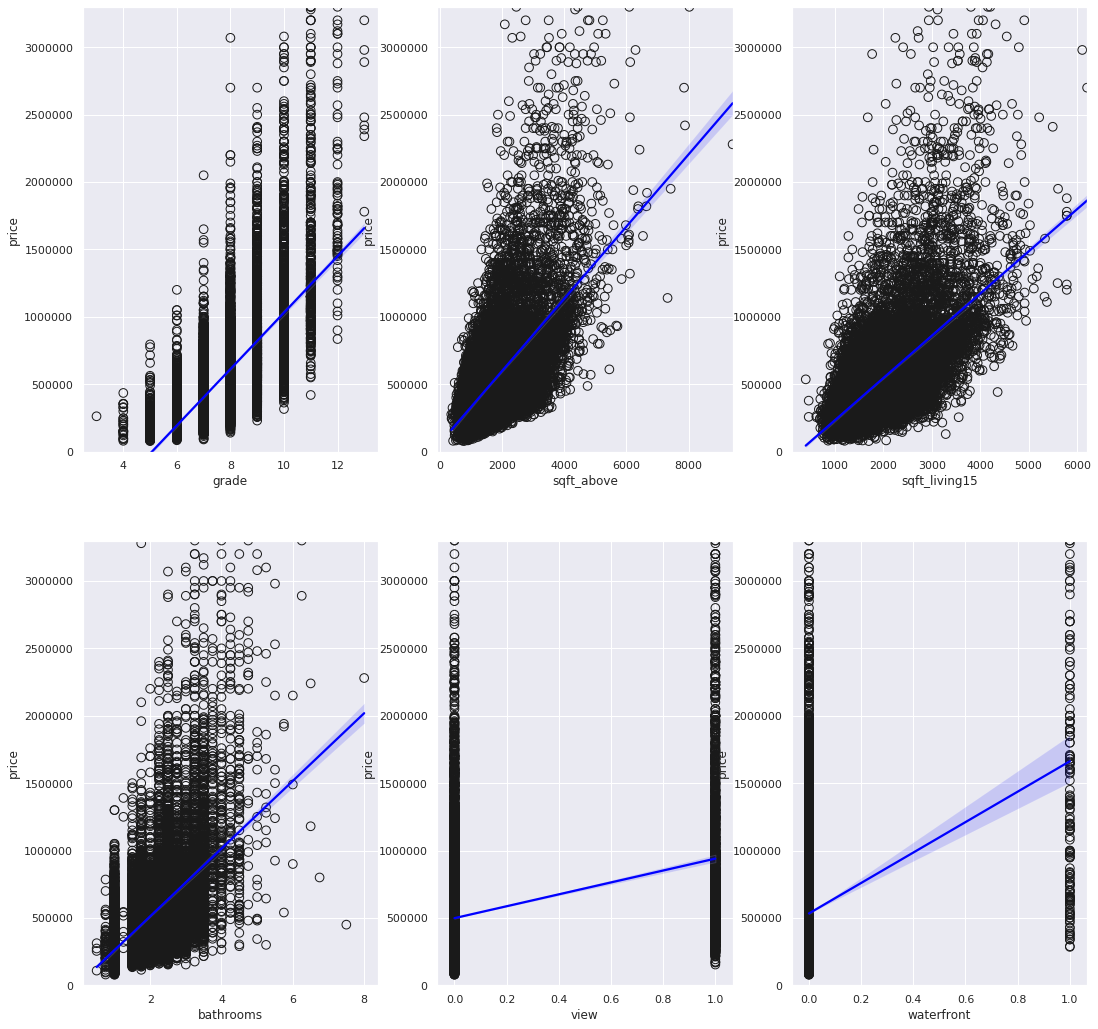

In [610]:
plt.figure(figsize=(18,18))
for i in range(6):
    ii = '23'+str(i+1)
    plt.subplot(ii)
    feature = corr_list.index.values[i]
    plt.scatter(rawdata[feature], rawdata['price'], facecolors='none',edgecolors='k',s = 75)
    sns.regplot(x = feature, y = 'price', data = rawdata,scatter=False, color = 'Blue')
    ax=plt.gca() 
    ax.set_ylim([0,3300000])

In [611]:
data = rawdata.copy()

### Now for further cleaning and to deal with the outliers

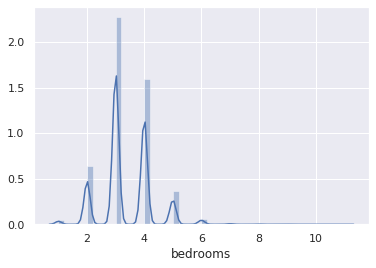

In [612]:
# The bedroom column has one massive outlier, which I will remove manually
data = data[data['bedrooms']<=11]
sns.distplot(data['bedrooms']) # Now has a slightly better distribution.

In [613]:
# The waterfront, view, and renovated columns have a big percentatge of 0 values, so will drop these entirely.
data = data.drop(["waterfront","view","renovated"], axis=1)

In [144]:
data.shape

(21419, 12)

### Dealing with the skewed data

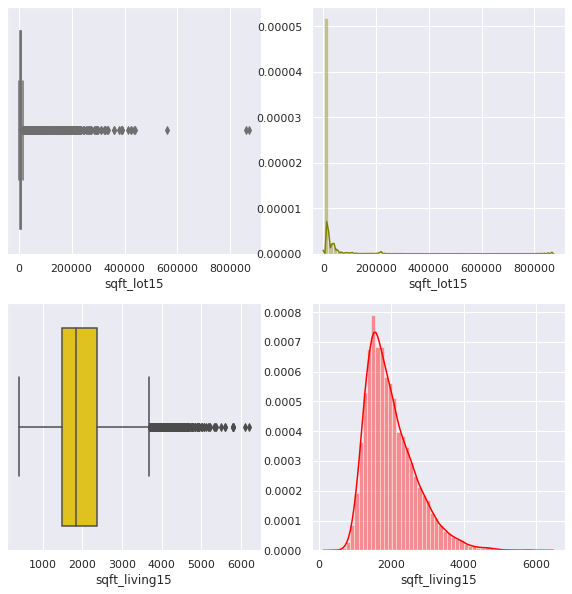

In [400]:
f, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=False)
sns.boxplot( data["sqft_lot15"] , color="skyblue", ax=axes[0, 0])
sns.distplot( data["sqft_lot15"] , color="olive", ax=axes[0, 1])
sns.boxplot( data["sqft_living15"] , color="gold", ax=axes[1, 0])
sns.distplot( data["sqft_living15"] , color="red", ax=axes[1, 1])

In [553]:
data["sqft_lot15_log"] = np.log(data["sqft_lot15"])
data["sqft_living15_log"] = np.log(data["sqft_living15"])

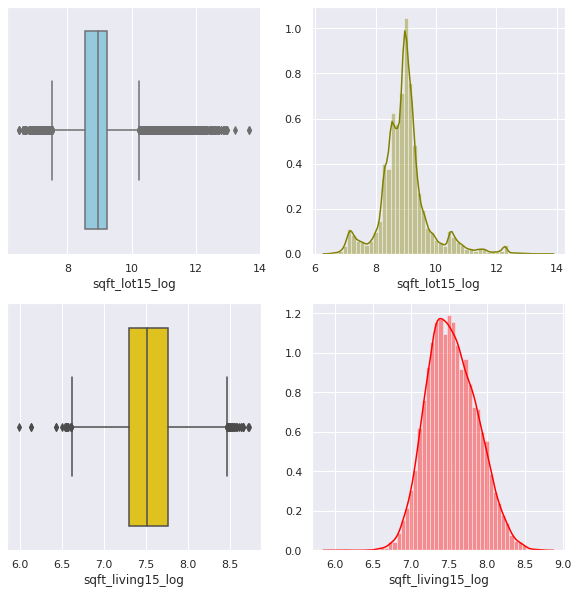

In [147]:
f, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=False)
sns.boxplot( data["sqft_lot15_log"] , color="skyblue", ax=axes[0, 0])
sns.distplot( data["sqft_lot15_log"] , color="olive", ax=axes[0, 1])
sns.boxplot( data["sqft_living15_log"] , color="gold", ax=axes[1, 0])
sns.distplot( data["sqft_living15_log"] , color="red", ax=axes[1, 1])

In [554]:
# The sqft_living15_log gives us a more normal distribution. So will drop the original column.
#The sqft_lot15_log has a worse distribution, so will drop this too and try another method.

data = data.drop(["sqft_living15","sqft_lot15_log"], axis=1)

In [555]:
data= data[['bedrooms', 'bathrooms', 'floors', 'condition', 'grade', 'sqft_above',
    'sqft_lot15','sqft_living15_log', 'sqft_basement','zipcode', 'yr_built','price']]

In [556]:
data.columns = ['bedrooms', 'bathrooms', 'floors', 'condition', 'grade', 'sqft_above',
       'sqft_lot15', 'sqft_living15_log', 'basement', 'zipcode',
       'yr_built', 'price']

###  *

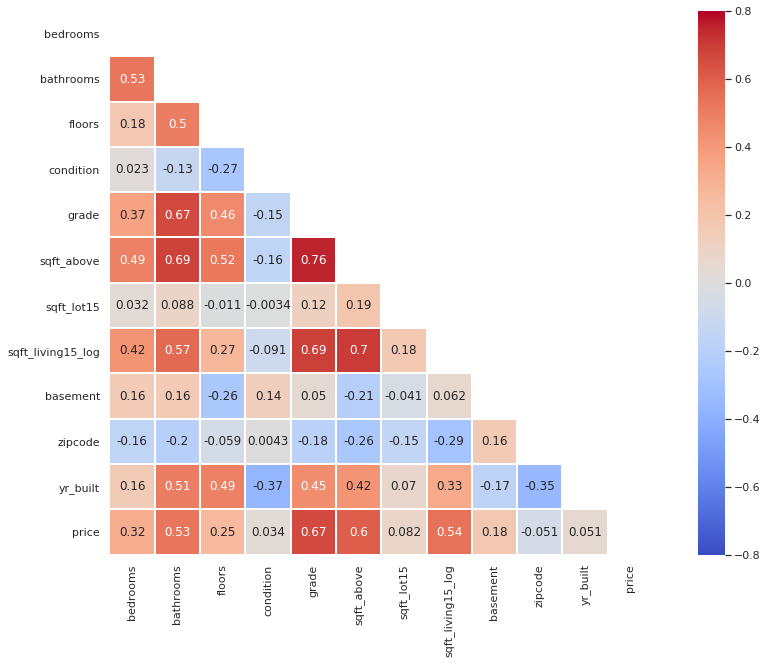

In [151]:
#A quick look at correlation may allow me to drop columns

mask = np.zeros_like(data.corr())
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(16, 10))
    ax = sns.heatmap(data.corr(), mask=mask,
                     square=True, linewidths=1, cmap="coolwarm",
                     vmax = 0.8, vmin = -0.8, annot=True )

In [152]:
# Looking at the heat map I can see that there are various columns with very little correlation to the price;
# These include zipcode, condition,sqdft_lot15, yr_built, basement. So will drop these now.

data = data.drop(["zipcode","condition","yr_built", "sqft_lot15", "basement"], axis=1)

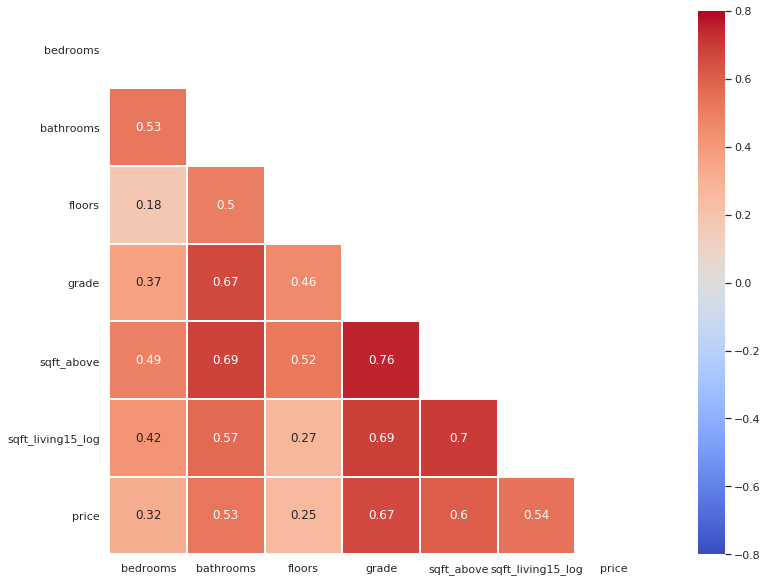

In [153]:
mask = np.zeros_like(data.corr())
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(16, 10))
    ax = sns.heatmap(data.corr(), mask=mask,
                     square=True, linewidths=1, cmap="coolwarm",
                     vmax = 0.8, vmin = -0.8, annot=True )

In [154]:
# There is lots of multicollinearity with the sqft_above and other columns, so will drop that column.
data = data.drop(["sqft_above"], axis=1)

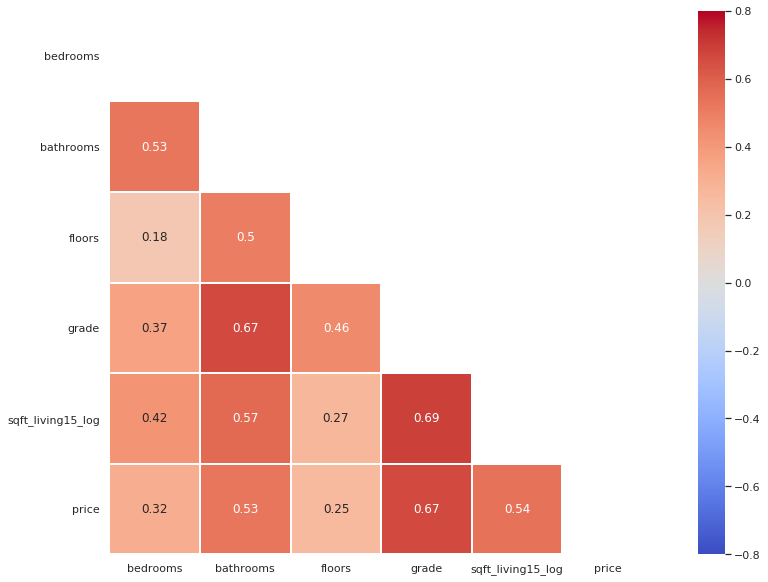

In [155]:
mask = np.zeros_like(data.corr())
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(16, 10))
    ax = sns.heatmap(data.corr(), mask=mask,
                     square=True, linewidths=1, cmap="coolwarm",
                     vmax = 0.8, vmin = -0.8,annot=True )

In [156]:
data_for_model = data.copy()

In [157]:
data_for_model = data_for_model.reset_index()
data_for_model = data_for_model.drop(["index"], axis=1)

### I will use a number of different regression models and compare the results 

In [192]:

data_for_model

,bedrooms,bathrooms,floors,grade,sqft_living15_log,price
0,6,3.00,2.0,7,7.630461,300000
1,4,1.75,1.0,8,7.859413,647500
2,3,1.00,1.0,7,7.718685,400000
3,3,1.00,1.5,6,7.162397,235000
4,4,2.00,1.0,7,7.299797,402500
...,...,...,...,...,...,...
21414,5,2.00,1.5,7,7.081709,365000
21415,2,1.00,1.0,7,7.565275,380000
21416,3,1.00,1.0,7,7.319865,339000
21417,2,1.75,1.5,9,7.272398,399900


In [191]:
# Now to try putting scaled data through a model to see if it improves it at all

In [206]:
transformer = StandardScaler().fit(data_for_model.iloc[:,:-1])
x_standardized = transformer.transform(data_for_model.iloc[:,:-1])

In [207]:
full_standardized = pd.DataFrame(x_standardized,columns=data_for_scaling.columns.tolist()[:-1])
full_standardized.head()
X = full_standardized
y = data_for_model['price']

In [208]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

In [209]:
knn_model = KNeighborsRegressor(n_neighbors=4)
knn_model.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=4)

In [210]:
knn_predictions = knn_model.predict(X_test)
MAE = mean_absolute_error(y_test,knn_predictions)
MSE = mean_squared_error(y_test,knn_predictions)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test,knn_predictions)

print("The mean absolute error of the model in the test set is: %6.2f" % (MAE))
print("The mean squared error of the model in the test set is: %6.2f" % (MSE))
print("The root mean squared error of the model in the test set is: %6.2f" % (RMSE))
print("The R2 of the model in the test set is: %4.2f" % (R2))

The mean absolute error of the model in the test set is: 156186.86
The mean squared error of the model in the test set is: 65410505780.90
The root mean squared error of the model in the test set is: 255754.78
The R2 of the model in the test set is: 0.53


In [214]:
lm = linear_model.LinearRegression()
lm_model = lm.fit(X_train,y_train)

In [215]:
MAE = mean_absolute_error(y_test,lm_predictions)
MSE = mean_squared_error(y_test,lm_predictions)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test,lm_predictions)

print("The mean absolute error of the model in the test set is: %6.2f" % (MAE))
print("The mean squared error of the model in the test set is: %6.2f" % (MSE))
print("The root mean squared error of the model in the test set is: %6.2f" % (RMSE))
print("The R2 of the model in the test set is: %4.2f" % (R2))

The mean absolute error of the model in the test set is: 172003.46
The mean squared error of the model in the test set is: 73700363746.73
The root mean squared error of the model in the test set is: 271478.11
The R2 of the model in the test set is: 0.47


In [216]:
scores = []
for i in range(2,10):
    model = KNeighborsRegressor(n_neighbors=i)
    model.fit(X_train, y_train)
    scores.append(model.score(X_test, y_test))

Text(0, 0.5, 'R2')

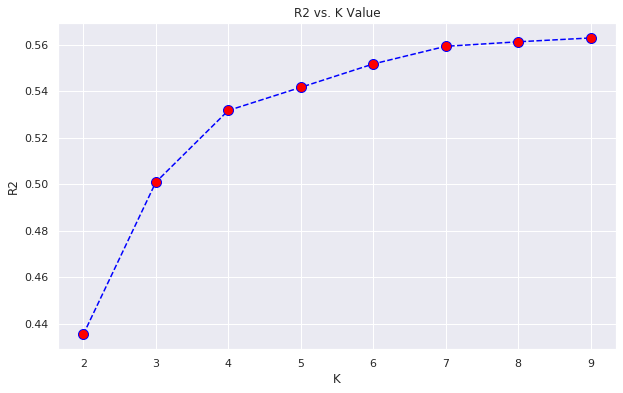

In [217]:
plt.figure(figsize=(10,6))
plt.plot(range(2,10),scores,color = 'blue', linestyle='dashed',
         marker='o', markerfacecolor='red', markersize=10)
plt.title('R2 vs. K Value')
plt.xlabel('K')
plt.ylabel('R2')

In [218]:
uniform_model = KNeighborsRegressor(n_neighbors=9)
uniform_model.fit(X_train, y_train)
uniform_predictions = uniform_model.predict(X_test)

MAE = mean_absolute_error(y_test,uniform_predictions)
MSE = mean_squared_error(y_test,uniform_predictions)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test,uniform_predictions)

print("The mean absolute error of the model in the test set is: %6.2f" % (MAE))
print("The mean squared error of the model in the test set is: %6.2f" % (MSE))
print("The root mean squared error of the model in the test set is: %6.2f" % (RMSE))
print("The R2 of the model in the test set is: %4.2f" % (R2))

The mean absolute error of the model in the test set is: 150138.21
The mean squared error of the model in the test set is: 61048461995.27
The root mean squared error of the model in the test set is: 247079.87
The R2 of the model in the test set is: 0.56


In [219]:
distance_model = KNeighborsRegressor(n_neighbors=9, weights = "distance")
distance_model.fit(X_train, y_train)
distance_predictions = distance_model.predict(X_test)

MAE = mean_absolute_error(y_test,distance_predictions)
MSE = mean_squared_error(y_test,distance_predictions)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test,distance_predictions)

print("The mean absolute error of the model in the test set is: %6.2f" % (MAE))
print("The mean squared error of the model in the test set is: %6.2f" % (MSE))
print("The root mean squared error of the model in the test set is: %6.2f" % (RMSE))
print("The R2 of the model in the test set is: %4.2f" % (R2))

The mean absolute error of the model in the test set is: 159081.33
The mean squared error of the model in the test set is: 68079390642.02
The root mean squared error of the model in the test set is: 260920.28
The R2 of the model in the test set is: 0.51


## The highest score of 0.56 came from the KNN uniform model.

In [158]:
transformer = StandardScaler().fit(data_for_model.iloc[:,:-1])
x_standardized = transformer.transform(data_for_model.iloc[:,:-1])

Index(['bedrooms', 'bathrooms', 'floors', 'grade', 'scaled_living15', 'price'], dtype='object')

In [ ]:
full_standardized = pd.DataFrame(x_standardized,columns=data_for_scaling.columns.tolist()[:-1])
full_standardized.head()

In [221]:

#I ran the code several times, dropping different collumns to see the effect on the outcome

#X = full_standardized.drop(["price",'bathrooms'], axis=1)
#X = full_standardized.drop(["price",'bedrooms'], axis=1)
#X = full_standardized.drop(["price",'grade'], axis=1)

X = full_standardized.drop(['floors'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

In [222]:
knn_model = KNeighborsRegressor(n_neighbors=4)
knn_model.fit(X_train, y_train)
knn_predictions = knn_model.predict(X_test)
MAE = mean_absolute_error(y_test,knn_predictions)
MSE = mean_squared_error(y_test,knn_predictions)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test,knn_predictions)

print("The mean absolute error of the model in the test set is: %6.2f" % (MAE))
print("The mean squared error of the model in the test set is: %6.2f" % (MSE))
print("The root mean squared error of the model in the test set is: %6.2f" % (RMSE))
print("The R2 of the model in the test set is: %4.2f" % (R2))

The mean absolute error of the model in the test set is: 163214.53
The mean squared error of the model in the test set is: 69120183004.79
The root mean squared error of the model in the test set is: 262907.18
The R2 of the model in the test set is: 0.51


In [223]:
lm = linear_model.LinearRegression()
lm_model = lm.fit(X_train,y_train)
lm_predictions = lm_model.predict(X_test)
MAE = mean_absolute_error(y_test,lm_predictions)
MSE = mean_squared_error(y_test,lm_predictions)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test,lm_predictions)

print("The mean absolute error of the model in the test set is: %6.2f" % (MAE))
print("The mean squared error of the model in the test set is: %6.2f" % (MSE))
print("The root mean squared error of the model in the test set is: %6.2f" % (RMSE))
print("The R2 of the model in the test set is: %4.2f" % (R2))

The mean absolute error of the model in the test set is: 172481.66
The mean squared error of the model in the test set is: 74406658575.69
The root mean squared error of the model in the test set is: 272775.84
The R2 of the model in the test set is: 0.47


In [224]:
uniform_model = KNeighborsRegressor(n_neighbors=9)
uniform_model.fit(X_train, y_train)
uniform_predictions = uniform_model.predict(X_test)

MAE = mean_absolute_error(y_test,uniform_predictions)
MSE = mean_squared_error(y_test,uniform_predictions)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test,uniform_predictions)

print("The mean absolute error of the model in the test set is: %6.2f" % (MAE))
print("The mean squared error of the model in the test set is: %6.2f" % (MSE))
print("The root mean squared error of the model in the test set is: %6.2f" % (RMSE))
print("The R2 of the model in the test set is: %4.2f" % (R2))

The mean absolute error of the model in the test set is: 155349.92
The mean squared error of the model in the test set is: 62648468327.97
The root mean squared error of the model in the test set is: 250296.76
The R2 of the model in the test set is: 0.55


In [225]:
distance_model = KNeighborsRegressor(n_neighbors=9, weights = "distance")
distance_model.fit(X_train, y_train)
distance_predictions = distance_model.predict(X_test)

MAE = mean_absolute_error(y_test,distance_predictions)
MSE = mean_squared_error(y_test,distance_predictions)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test,distance_predictions)

print("The mean absolute error of the model in the test set is: %6.2f" % (MAE))
print("The mean squared error of the model in the test set is: %6.2f" % (MSE))
print("The root mean squared error of the model in the test set is: %6.2f" % (RMSE))
print("The R2 of the model in the test set is: %4.2f" % (R2))

The mean absolute error of the model in the test set is: 165530.24
The mean squared error of the model in the test set is: 71766778940.25
The root mean squared error of the model in the test set is: 267893.22
The R2 of the model in the test set is: 0.49


# Now to try using some dummies

In [226]:
bathrooms = data_for_model['bathrooms']
floor = data_for_model['floors']
bedrooms = data_for_model['bedrooms']
grade = data_for_model['grade']

In [227]:
bedrooms_encoded = pd.get_dummies(bedrooms, drop_first=True)

In [230]:
bedrooms_encoded.columns = ['bed2','bed3','bed4','bed5','bed6','bed7','bed8','bed9','bed10', 'bed11']
bedrooms_encoded

,bed2,bed3,bed4,bed5,bed6,bed7,bed8,bed9,bed10,bed11
0,0,0,0,0,1,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
21414,0,0,0,1,0,0,0,0,0,0
21415,1,0,0,0,0,0,0,0,0,0
21416,0,1,0,0,0,0,0,0,0,0
21417,1,0,0,0,0,0,0,0,0,0


In [231]:
floors_encoded = pd.get_dummies(floor, drop_first=True)
floors_encoded.columns = ['fl1.5','fl2.0','fl2.5','fl3.0','fl3.5']
floors_encoded

,fl1.5,fl2.0,fl2.5,fl3.0,fl3.5
0,0,1,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,1,0,0,0,0
4,0,0,0,0,0
...,...,...,...,...,...
21414,1,0,0,0,0
21415,0,0,0,0,0
21416,0,0,0,0,0
21417,1,0,0,0,0


In [232]:
bathrooms_encoded = pd.get_dummies(bathrooms, drop_first=True)
#floors_encoded.columns = ['fl1.5','fl2.0','fl2.5','fl3.0','fl3.5']
bathrooms_encoded

,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00,3.25,3.50,3.75,4.00,4.25,4.50,4.75,5.00,5.25,5.50,5.75,6.00,6.25,6.50,6.75,7.50,7.75,8.00
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21414,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
21415,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
21416,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
21417,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [233]:
grade_encoded = pd.get_dummies(grade, drop_first=True)
grade_encoded.columns = ['gr4','gr5','gr6','gr7','gr8','gr9','gr10','gr11','gr12','gr13']
grade_encoded


,gr4,gr5,gr6,gr7,gr8,gr9,gr10,gr11,gr12,gr13
0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
21414,0,0,0,1,0,0,0,0,0,0
21415,0,0,0,1,0,0,0,0,0,0
21416,0,0,0,1,0,0,0,0,0,0
21417,0,0,0,0,0,1,0,0,0,0


In [234]:
encoded_data = pd.concat([bedrooms_encoded,bathrooms_encoded,grade_encoded,floors_encoded],axis=1)
encoded_data

,bed2,bed3,bed4,bed5,bed6,bed7,bed8,bed9,bed10,bed11,0.75,1.0,1.25,1.5,1.75,2.0,2.25,2.5,2.75,3.0,3.25,3.5,3.75,4.0,4.25,4.5,4.75,5.0,5.25,5.5,5.75,6.0,6.25,6.5,6.75,7.5,7.75,8.0,gr4,gr5,gr6,gr7,gr8,gr9,gr10,gr11,gr12,gr13,fl1.5,fl2.0,fl2.5,fl3.0,fl3.5
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21414,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
21415,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
21416,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
21417,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0


In [235]:
for_encoded = scaled_data.drop(["bedrooms","bathrooms","floors","grade"], axis=1)

In [236]:
encoded_scaled_data = pd.concat([encoded_data,for_encoded],axis=1)
encoded_scaled_data

,bed2,bed3,bed4,bed5,bed6,bed7,bed8,bed9,bed10,bed11,0.75,1.0,1.25,1.5,1.75,2.0,2.25,2.5,2.75,3.0,3.25,3.5,3.75,4.0,4.25,4.5,4.75,5.0,5.25,5.5,5.75,6.0,6.25,6.5,6.75,7.5,7.75,8.0,gr4,gr5,gr6,gr7,gr8,gr9,gr10,gr11,gr12,gr13,fl1.5,fl2.0,fl2.5,fl3.0,fl3.5,scaled_living15,price
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0.274995,300000
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.974231,647500
2,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.544439,400000
3,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,-1.154505,235000
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,-0.734876,402500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21414,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,-1.400935,365000
21415,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.075913,380000
21416,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,-0.673588,339000
21417,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,-0.818555,399900


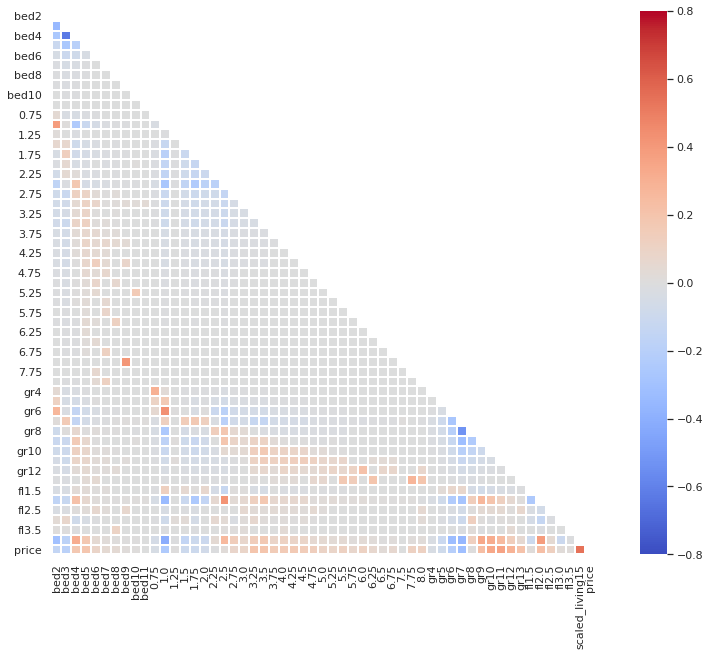

In [237]:
mask = np.zeros_like(encoded_scaled_data.corr())
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(16, 10))
    ax = sns.heatmap(encoded_scaled_data.corr(), mask=mask,
                     square=True, linewidths=1, cmap="coolwarm",
                     vmax = 0.8, vmin = -0.8)

In [241]:
encoded_2 = encoded_scaled_data.drop(['bed2','bed3','bed6', 'bed7','bed8','bed8','bed9','bed10',0.75,1.0,1.25,1.5,1.75,2.0,2.25,2.5,2.75,3.0,
3.75,4.0,4.25,4.5,4.75,5.0,5.25,5.5,5.75,6.0,6.5,6.75,7.5,
'gr4','gr5','gr6','gr7','gr8','fl1.5','fl2.5','fl3.0','fl3.5'], axis=1)


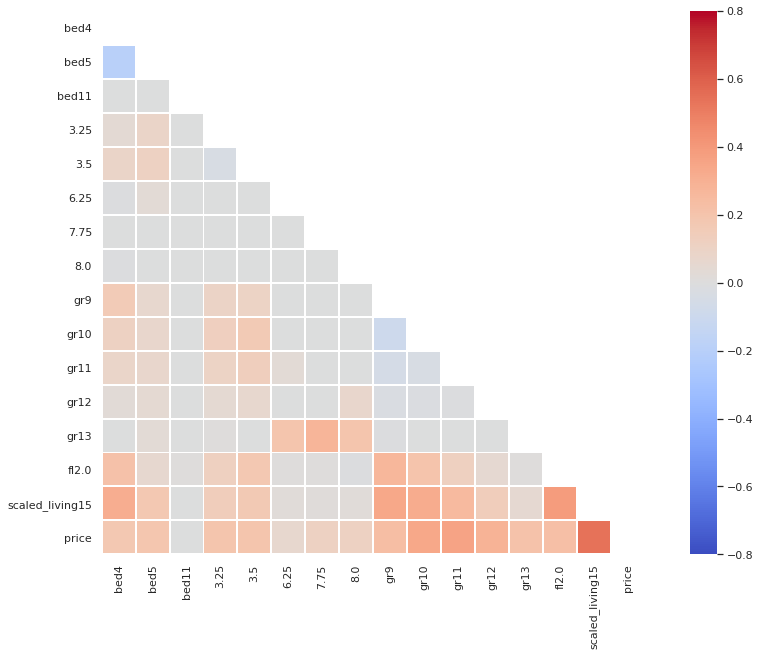

In [242]:
mask = np.zeros_like(encoded_2.corr())
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(16, 10))
    ax = sns.heatmap(encoded_2.corr(), mask=mask,
                     square=True, linewidths=1, cmap="coolwarm",
                     vmax = 0.8, vmin = -0.8)

In [246]:
#encoded_2 = encoded_2.drop(['bed11','gr13'])

In [247]:
encoded_2.head()

,bed4,bed5,bed11,3.25,3.5,6.25,7.75,8.0,gr9,gr10,gr11,gr12,gr13,fl2.0,scaled_living15,price
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.274995,300000
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.974231,647500
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.544439,400000
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.154505,235000
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.734876,402500


In [180]:
#Now to test this in some models

In [255]:
y = encoded_2['price']
X = encoded_2.drop(["price","bed11","gr13"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

In [256]:
knn_model = KNeighborsRegressor(n_neighbors=4)
knn_model.fit(X_train, y_train)
knn_predictions = knn_model.predict(X_test)
MAE = mean_absolute_error(y_test,knn_predictions)
MSE = mean_squared_error(y_test,knn_predictions)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test,knn_predictions)

print("The mean absolute error of the model in the test set is: %6.2f" % (MAE))
print("The mean squared error of the model in the test set is: %6.2f" % (MSE))
print("The root mean squared error of the model in the test set is: %6.2f" % (RMSE))
print("The R2 of the model in the test set is: %4.2f" % (R2))

The mean absolute error of the model in the test set is: 176830.54
The mean squared error of the model in the test set is: 80659821042.13
The root mean squared error of the model in the test set is: 284006.73
The R2 of the model in the test set is: 0.42


In [257]:
lm = linear_model.LinearRegression()
lm_model = lm.fit(X_train,y_train)
lm_predictions = lm_model.predict(X_test)
MAE = mean_absolute_error(y_test,lm_predictions)
MSE = mean_squared_error(y_test,lm_predictions)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test,lm_predictions)

print("The mean absolute error of the model in the test set is: %6.2f" % (MAE))
print("The mean squared error of the model in the test set is: %6.2f" % (MSE))
print("The root mean squared error of the model in the test set is: %6.2f" % (RMSE))
print("The R2 of the model in the test set is: %4.2f" % (R2))

The mean absolute error of the model in the test set is: 164693.30
The mean squared error of the model in the test set is: 67388329412.63
The root mean squared error of the model in the test set is: 259592.62
The R2 of the model in the test set is: 0.52


In [258]:
lm.score(X_test,y_test)

0.5175512316716584

In [259]:
uniform_model = KNeighborsRegressor(n_neighbors=9)
uniform_model.fit(X_train, y_train)
uniform_predictions = uniform_model.predict(X_test)

MAE = mean_absolute_error(y_test,uniform_predictions)
MSE = mean_squared_error(y_test,uniform_predictions)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test,uniform_predictions)

print("The mean absolute error of the model in the test set is: %6.2f" % (MAE))
print("The mean squared error of the model in the test set is: %6.2f" % (MSE))
print("The root mean squared error of the model in the test set is: %6.2f" % (RMSE))
print("The R2 of the model in the test set is: %4.2f" % (R2))

The mean absolute error of the model in the test set is: 167528.89
The mean squared error of the model in the test set is: 73348979406.22
The root mean squared error of the model in the test set is: 270830.17
The R2 of the model in the test set is: 0.47


In [260]:
distance_model = KNeighborsRegressor(n_neighbors=9, weights = "distance")
distance_model.fit(X_train, y_train)
distance_predictions = distance_model.predict(X_test)

MAE = mean_absolute_error(y_test,distance_predictions)
MSE = mean_squared_error(y_test,distance_predictions)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test,distance_predictions)

print("The mean absolute error of the model in the test set is: %6.2f" % (MAE))
print("The mean squared error of the model in the test set is: %6.2f" % (MSE))
print("The root mean squared error of the model in the test set is: %6.2f" % (RMSE))
print("The R2 of the model in the test set is: %4.2f" % (R2))

The mean absolute error of the model in the test set is: 175270.23
The mean squared error of the model in the test set is: 83730242554.93
The root mean squared error of the model in the test set is: 289361.78
The R2 of the model in the test set is: 0.40


### Using the dummy columns the highest score was 0.52 with the lm_model

### Using the Dummys didn't improve the score of my model. So will try go back and try to refine each part.

In [261]:
# I will try puttin more data into different models to see the effects. 

In [614]:
data

,bedrooms,bathrooms,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15,price
2495,6,3.000,2.000,0,0,3,7,2400,0,1991,98002,2060,7316,300000
6729,4,1.750,1.000,0,0,4,8,1160,1,1947,98166,2590,21891,647500
8404,3,1.000,1.000,0,0,3,7,1460,0,1952,98166,2250,20023,400000
8800,3,1.000,1.500,0,0,4,6,1010,1,1930,98168,1290,10320,235000
3553,4,2.000,1.000,0,0,3,7,760,1,1951,98144,1480,3504,402500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16723,5,2.000,1.500,0,0,3,7,1600,0,1927,98126,1190,4168,365000
3257,2,1.000,1.000,0,0,5,7,840,1,1939,98126,1930,5150,380000
7614,3,1.000,1.000,0,0,4,7,720,1,1942,98126,1510,4538,339000
20963,2,1.750,1.500,0,0,3,9,900,1,2011,98027,1440,1188,399900


In [615]:
transformer = StandardScaler().fit(data.iloc[:,:-1])
x_standardized = transformer.transform(data.iloc[:,:-1])

In [616]:
full_standardized = pd.DataFrame(x_standardized,columns=data.columns.tolist()[:-1])

In [617]:
reg = LinearRegression()
y = data['price']
X = full_standardized

In [618]:
x_train , x_test , y_train , y_test = train_test_split(X , y , test_size = 0.20,random_state =2)

In [619]:
reg.fit(x_train,y_train)

LinearRegression()

In [620]:
reg.score(x_test,y_test)

0.6569436632031598

In [621]:
lm = linear_model.LinearRegression()
lm_model = lm.fit(x_train,y_train)
lm_predictions = lm_model.predict(x_test)
MAE = mean_absolute_error(y_test,lm_predictions)
MSE = mean_squared_error(y_test,lm_predictions)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test,lm_predictions)

print("The mean absolute error of the model in the test set is: %6.2f" % (MAE))
print("The mean squared error of the model in the test set is: %6.2f" % (MSE))
print("The root mean squared error of the model in the test set is: %6.2f" % (RMSE))
print("The R2 of the model in the test set is: %4.2f" % (R2))

The mean absolute error of the model in the test set is: 139752.51
The mean squared error of the model in the test set is: 46187881464.45
The root mean squared error of the model in the test set is: 214913.66
The R2 of the model in the test set is: 0.66


In [622]:
distance_model = KNeighborsRegressor(n_neighbors=9, weights = "distance")
distance_model.fit(x_train, y_train)
distance_predictions = distance_model.predict(x_test)

MAE = mean_absolute_error(y_test,distance_predictions)
MSE = mean_squared_error(y_test,distance_predictions)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test,distance_predictions)

print("The mean absolute error of the model in the test set is: %6.2f" % (MAE))
print("The mean squared error of the model in the test set is: %6.2f" % (MSE))
print("The root mean squared error of the model in the test set is: %6.2f" % (RMSE))
print("The R2 of the model in the test set is: %4.2f" % (R2))

The mean absolute error of the model in the test set is: 116743.67
The mean squared error of the model in the test set is: 36293685206.55
The root mean squared error of the model in the test set is: 190509.02
The R2 of the model in the test set is: 0.73


In [623]:
from sklearn import ensemble
clf = ensemble.GradientBoostingRegressor(n_estimators = 400, max_depth = 5, min_samples_split = 2,
          learning_rate = 0.1, loss = 'ls')

In [624]:
clf.fit(x_train, y_train)

GradientBoostingRegressor(max_depth=5, n_estimators=400)

In [625]:
clf.score(x_test,y_test)


0.8409900192415798

### Using more data has given me a much better result. So will explore some of the preditions

In [626]:
y_pred = distance_model.predict(x_test)


In [627]:
y_pred

array([504597.8450288 , 362995.97897193, 408776.05777077, ...,
       336052.49535786, 684944.58153236, 273589.87259898])

In [628]:
predictions = pd.DataFrame(y_pred)
predictions.info()
predictions.columns = ['predicted_price']
pd.set_option('display.float_format', lambda x: '%.3f' % x)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4284 entries, 0 to 4283
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       4284 non-null   float64
dtypes: float64(1)
memory usage: 33.6 KB


In [629]:
actuals = pd.DataFrame(y_test)

In [630]:
actuals.reset_index(drop=True, inplace=True)
predictions.reset_index(drop=True, inplace=True)
comparisson = pd.concat([actuals, predictions], axis=1)

In [631]:
comparisson['difference'] = abs(comparisson['price'] - comparisson['predicted_price'] )

In [650]:
comparisson['percentage'] = (comparisson['difference'] )/comparisson['price'] *100

In [651]:
comparisson

,price,predicted_price,difference,perctage,percentage
0,258000,504597.845,246597.845,95.581,95.581
1,385000,362995.979,22004.021,5.715,5.715
2,459500,408776.058,50723.942,11.039,11.039
3,1580000,1081401.758,498598.242,31.557,31.557
4,500000,350626.127,149373.873,29.875,29.875
...,...,...,...,...,...
4279,147200,226567.032,79367.032,53.918,53.918
4280,329950,438137.834,108187.834,32.789,32.789
4281,211000,336052.495,125052.495,59.267,59.267
4282,912000,684944.582,227055.418,24.896,24.896


In [652]:
comparisson.mean(axis=0)

price             543177.958
predicted_price   528755.459
difference        116743.669
perctage              22.902
percentage            22.902
dtype: float64

In [653]:
gradient_model_pred= clf.predict(x_test)

In [654]:
gradpredictions = pd.DataFrame(gradient_model_pred)
#predictions.info()
gradpredictions.columns = ['predicted_price']

In [655]:
actuals.reset_index(drop=True, inplace=True)
gradpredictions.reset_index(drop=True, inplace=True)
gradcomparisson = pd.concat([actuals, gradpredictions], axis=1)

In [656]:
gradcomparisson['difference'] = abs(gradcomparisson['price'] - gradcomparisson['predicted_price'])

In [657]:
gradcomparisson['percentage'] = (gradcomparisson['difference'] )/gradcomparisson['price'] *100

In [658]:
gradcomparisson

,price,predicted_price,difference,percentage
0,258000,389830.630,131830.630,51.097
1,385000,365654.329,19345.671,5.025
2,459500,352965.199,106534.801,23.185
3,1580000,1413868.295,166131.705,10.515
4,500000,485720.555,14279.445,2.856
...,...,...,...,...
4279,147200,244575.277,97375.277,66.152
4280,329950,296561.551,33388.449,10.119
4281,211000,249284.544,38284.544,18.144
4282,912000,923887.977,11887.977,1.304


In [659]:
gradcomparisson.mean(axis=0)

price             543177.958
predicted_price   539626.472
difference         75746.452
percentage            13.685
dtype: float64